# Risk Assessment of Legal Contracts Using CUAD Dataset

## Step 1: Load relevant libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import os

## Step 2: Load the `master_clause.csv` file

In [4]:
df = pd.read_csv("CUAD_v1/master_clauses.csv")

print("Shape of dataset:", df.shape)
df.head(3)

Shape of dataset: (510, 83)


,Filename,Document Name,Document Name-Answer,Parties,Parties-Answer,Agreement Date,Agreement Date-Answer,Effective Date,Effective Date-Answer,Expiration Date,...,Liquidated Damages,Liquidated Damages-Answer,Warranty Duration,Warranty Duration-Answer,Insurance,Insurance-Answer,Covenant Not To Sue,Covenant Not To Sue-Answer,Third Party Beneficiary,Third Party Beneficiary-Answer
0,CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...,['MARKETING AFFILIATE AGREEMENT'],MARKETING AFFILIATE AGREEMENT,"['BIRCH FIRST GLOBAL INVESTMENTS INC.', 'MA', ...","Birch First Global Investments Inc. (""Company""...","['8th day of May 2014', 'May 8, 2014']",5/8/14,['This agreement shall begin upon the date of ...,NaN,['This agreement shall begin upon the date of ...,...,[],No,"[""COMPANY'S SOLE AND EXCLUSIVE LIABILITY FOR T...",Yes,[],No,[],No,[],No
1,EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...,['VIDEO-ON-DEMAND CONTENT LICENSE AGREEMENT'],VIDEO-ON-DEMAND CONTENT LICENSE AGREEMENT,"['EuroMedia Holdings Corp.', 'Rogers', 'Rogers...","Rogers Cable Communications Inc. (""Rogers""); E...","['July 11 , 2006']",7/11/06,"['July 11 , 2006']",7/11/06,"['The term of this Agreement (the ""Initial Ter...",...,[],No,[],No,[],No,[],No,[],No
2,FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...,['CONTENT DISTRIBUTION AND LICENSE AGREEMENT'],CONTENT DISTRIBUTION AND LICENSE AGREEMENT,"['Producer', 'Fulucai Productions Ltd.', 'Conv...","CONVERGTV, INC. (“ConvergTV”); Fulucai Product...","['November 15, 2012']",11/15/12,"['November 15, 2012']",11/15/12,[],...,[],No,[],No,[],No,[],No,[],No


We inspect the data further.

In [11]:
# Check column names
df.rename(columns={'Notice Period To Terminate Renewal- Answer': 'Notice Period To Terminate Renewal-Answer'}, inplace=True)
print(df.columns)

# Check for missing values
print(df.isnull().sum())

# Preview label distribution
label_cols = df.columns[3:]  # First 3 columns assumed to be metadata
print("Labels:", label_cols.tolist())

# Count non-null entries for each label
label_counts = df[label_cols].notnull().sum().sort_values(ascending=False)
print("Non-null counts for each label:")
print(label_counts)

Index(['Filename', 'Document Name', 'Document Name-Answer', 'Parties',
       'Parties-Answer', 'Agreement Date', 'Agreement Date-Answer',
       'Effective Date', 'Effective Date-Answer', 'Expiration Date',
       'Expiration Date-Answer', 'Renewal Term', 'Renewal Term-Answer',
       'Notice Period To Terminate Renewal',
       'Notice Period To Terminate Renewal-Answer', 'Governing Law',
       'Governing Law-Answer', 'Most Favored Nation',
       'Most Favored Nation-Answer', 'Competitive Restriction Exception',
       'Competitive Restriction Exception-Answer', 'Non-Compete',
       'Non-Compete-Answer', 'Exclusivity', 'Exclusivity-Answer',
       'No-Solicit Of Customers', 'No-Solicit Of Customers-Answer',
       'No-Solicit Of Employees', 'No-Solicit Of Employees-Answer',
       'Non-Disparagement', 'Non-Disparagement-Answer',
       'Termination For Convenience', 'Termination For Convenience-Answer',
       'Rofr/Rofo/Rofn', 'Rofr/Rofo/Rofn-Answer', 'Change Of Control',
       

## Step 3: Prepare dataset for model training

### Splitting dataset into training, validation and test sets.
Due to computational limitations, we use only 15% of the full dataset, then splitting this portion into 70% train, 15% validation and 15% test.

In [15]:
# Step 1: Build long-form dataset
long_data = []

for col in df.columns:
    if col.endswith("-Answer"):
        label = col.replace("-Answer", "").strip()
        answer_col = col
        clause_col = label  # This should match the non-Answer column

        if clause_col in df.columns:
            for clause_text in df[clause_col]:
                long_data.append((clause_text, label))

# Convert to DataFrame
long_df = pd.DataFrame(long_data, columns=["clause_text", "clause_type"])

# Clean up
long_df = long_df[long_df["clause_text"].notna() & (long_df["clause_text"].str.strip() != "[]")]
long_df["clause_text"] = long_df["clause_text"].str.replace(r"^\[|\]$", "", regex=True).str.strip("'\" ")
long_df = long_df.drop_duplicates()

# === NEW STEP: Sample 15% of the whole dataset ===
from sklearn.model_selection import train_test_split

# Sample 15% of the full dataset
sampled_df, _ = train_test_split(
    long_df, stratify=long_df["clause_type"], test_size=0.85, random_state=42)

# First split: Train vs Temp (70/30)
try:
    train_df, temp_df = train_test_split(
        sampled_df, stratify=sampled_df["clause_type"], test_size=0.3, random_state=42)
except ValueError:
    train_df, temp_df = train_test_split(
        sampled_df, test_size=0.3, random_state=42)

# Second split: Temp into Val and Test (50/50)
try:
    val_df, test_df = train_test_split(
        temp_df, stratify=temp_df["clause_type"], test_size=0.5, random_state=42)
except ValueError:
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, random_state=42)

# Extract texts and labels
train_texts, train_labels = train_df["clause_text"], train_df["clause_type"]
val_texts, val_labels = val_df["clause_text"], val_df["clause_type"]
test_texts, test_labels = test_df["clause_text"], test_df["clause_type"]

# Print counts
print("Train size:", len(train_texts))
print("Validation size:", len(val_texts))
print("Test size:", len(test_texts))

Train size: 672
Validation size: 144
Test size: 145


In [17]:
print(long_df.iloc[:600])

                                           clause_text    clause_type
0                        MARKETING AFFILIATE AGREEMENT  Document Name
1            VIDEO-ON-DEMAND CONTENT LICENSE AGREEMENT  Document Name
2           CONTENT DISTRIBUTION AND LICENSE AGREEMENT  Document Name
3                    WEBSITE CONTENT LICENSE AGREEMENT  Document Name
4                            CONTENT LICENSE AGREEMENT  Document Name
..                                                 ...            ...
838  Zhongshan Nissin Industry Co., Ltd.', 'Nissin ...        Parties
839  KIROMIC BIOPHARMA Inc.', 'MOLIPHARMA S.R.L.', ...        Parties
840  MIL', which terms shall unless repugnant to th...        Parties
841  Physician Sales & Service, Inc.', 'PSS', 'Gulf...        Parties
842  Federal  Deposit Insurance  Corporation', 'Ams...        Parties

[600 rows x 2 columns]


### Tokenize the data

In [19]:
from transformers import BertTokenizer

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize data
def tokenize(texts):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

C:\Users\Ryhana Rasidi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [21]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_enc = torch.tensor(label_encoder.fit_transform(train_labels))
val_labels_enc = torch.tensor(label_encoder.transform(val_labels))
test_labels_enc = torch.tensor(label_encoder.transform(test_labels))

# Store class names
class_names = label_encoder.classes_

In [23]:
from torch.utils.data import Dataset

class ClauseDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ClauseDataset(train_encodings, train_labels_enc)
val_dataset = ClauseDataset(val_encodings, val_labels_enc)
test_dataset = ClauseDataset(test_encodings, test_labels_enc)

### Task: Single-clause classification for BERT base model

In [424]:
from transformers import BertForSequenceClassification

num_labels = len(class_names)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

C:\Users\Ryhana Rasidi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Define the performance metrics: Accuracy, precision, recall and F1-score.

In [425]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

### Model setup

In [428]:
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader

training_args = TrainingArguments(
    output_dir="./results",          # where to save model checkpoints
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    evaluation_strategy="epoch",     # evaluate at end of each epoch
    save_strategy="epoch",           # save at end of each epoch
    logging_dir="./logs",            # directory for logs
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # we’ll define accuracy next
    save_total_limit=1,              # keep only 1 best model
    report_to="none"                 # turn off WandB or other reporters
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [430]:
print('Training start...')
trainer.train()
print('Training done.')

trainer.save_model("bert_clause_classifier")
tokenizer.save_pretrained("bert_clause_classifier")
print('Model saved.')

Training start...


C:\Users\Ryhana Rasidi\AppData\Local\Temp\ipykernel_5288\3762311827.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\Ryhana Rasidi\AppData\Local\Temp\ipykernel_5288\3762311827.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,3.407300,2.982237,0.298611,0.249177,0.298611,0.216596


C:\Users\Ryhana Rasidi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training done.
Model saved.


### Task: Multi-clause classification for BERT base model

In [482]:
from torch.utils.data import Dataset

class ClauseDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels  # Should be list/array of 41-length vectors (e.g., [0,1,0,...])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)  # changed from long to float
        return item

    def __len__(self):
        return len(self.labels)

num_classes = 41

def to_multi_hot(label_list, num_classes):
    multi_hot = np.zeros((len(label_list), num_classes), dtype=int)
    for i, labels in enumerate(label_list):
        for label in labels:
            multi_hot[i][label] = 1
    return multi_hot

train_labels_enc = to_multi_hot(train_labels_enc, num_classes)
val_labels_enc = to_multi_hot(val_labels_enc, num_classes)
test_labels_enc = to_multi_hot(test_labels_enc, num_classes)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize data
def tokenize(texts):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

train_dataset = ClauseDataset(train_encodings, train_labels_enc)
val_dataset = ClauseDataset(val_encodings, val_labels_enc)
test_dataset = ClauseDataset(test_encodings, test_labels_enc)

C:\Users\Ryhana Rasidi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [484]:
print(torch.tensor(train_labels_enc).shape)

torch.Size([672, 41])


In [486]:
# BERT: Multi-clause classification
from transformers import BertPreTrainedModel, BertModel
import torch.nn as nn

# Custom model for multi-label classification
class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(config.hidden_size, 41)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits, labels.float())

        return (loss, logits) if loss is not None else logits

# Instantiate model
model = BertForMultiLabelClassification.from_pretrained("bert-base-uncased")

# Metric function
def compute_metrics(pred):
    logits, labels = pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs > 0.5).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='samples', zero_division=0)
    acc = (preds == labels).mean()

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./multiresults",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,   # must return (input_ids, attention_mask, labels (multi-hot))
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

C:\Users\Ryhana Rasidi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForMultiLabelClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [488]:
print("Training start...")
trainer.train()
print("Training done.")

# Save model + tokenizer
trainer.save_model("bert_multilabel_clause_classifier")
tokenizer.save_pretrained("bert_multilabel_clause_classifier")
print("Model saved.")

Training start...


C:\Users\Ryhana Rasidi\AppData\Local\Temp\ipykernel_5288\451206218.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.349900,0.134954,1.000000,1.000000,1.000000,1.000000


Training done.
Model saved.


### Task: Single-clause classification for LegalBERT

In [436]:
from transformers import BertForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import Trainer, TrainingArguments
import torch
import numpy as np

# Step 1: Load the LegalBERT model
num_labels = len(class_names)
model = BertForSequenceClassification.from_pretrained("nlpaueb/legal-bert-base-uncased", num_labels=num_labels)

# Step 2: Compute metrics function
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Step 3: Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",          # where to save model checkpoints
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    evaluation_strategy="epoch",     # evaluate at end of each epoch
    save_strategy="epoch",           # save at end of each epoch
    logging_dir="./logs",            # directory for logs
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # we’ll define accuracy next
    save_total_limit=1,              # keep only 1 best model
    report_to="none"                 # turn off WandB or other reporters
)

# Step 4: Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

C:\Users\Ryhana Rasidi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [438]:
print('Training start...')
trainer.train()
print('Training done.')

# Step 5: Save the model
trainer.save_model("legal_bert_clause_classifier")
tokenizer.save_pretrained("legal_bert_clause_classifier")
print('Model saved.')

Training start...


C:\Users\Ryhana Rasidi\AppData\Local\Temp\ipykernel_5288\3762311827.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\Ryhana Rasidi\AppData\Local\Temp\ipykernel_5288\3762311827.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,3.458400,3.148536,0.229167,0.112837,0.229167,0.123921


C:\Users\Ryhana Rasidi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Checkpoint destination directory ./results\checkpoint-84 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Training done.
Model saved.


### Test 2: LegalBERT, single-clause classification

In [27]:
from transformers import BertForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import Trainer, TrainingArguments
import torch
import numpy as np

# Step 1: Load the LegalBERT model
num_labels = len(class_names)
model = BertForSequenceClassification.from_pretrained("nlpaueb/legal-bert-base-uncased", num_labels=num_labels)

# Step 2: Compute metrics function
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Step 3: Set up training arguments
training_args_2 = TrainingArguments(
    output_dir="./resultstest2",          # where to save model checkpoints
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=32,   # batch size for training
    per_device_eval_batch_size=32,    # batch size for evaluation
    evaluation_strategy="epoch",     # evaluate at end of each epoch
    save_strategy="epoch",           # save at end of each epoch
    logging_dir="./logs",            # directory for logs
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # we’ll define accuracy next
    save_total_limit=1,              # keep only 1 best model
    report_to="none"                 # turn off WandB or other reporters
)

# Step 4: Train the model
trainer2 = Trainer(
    model=model,
    args=training_args_2,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

C:\Users\Ryhana Rasidi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print('Training LegalBERT2 start...')
trainer2.train()
print('Training done.')

# Step 5: Save the model
trainer.save_model("legal_bert2_clause_classifier")
tokenizer.save_pretrained("legal_bert2_clause_classifier")
print('Model saved.')

Training LegalBERT2 start...


C:\Users\Ryhana Rasidi\AppData\Local\Temp\ipykernel_5288\3141951393.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


### Task: Multi-clause classification for LegalBERT

In [490]:
from torch.utils.data import Dataset

class ClauseDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels  # Should be list/array of 41-length vectors (e.g., [0,1,0,...])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)  # changed from long to float
        return item

    def __len__(self):
        return len(self.labels)

num_classes = 41

def to_multi_hot(label_list, num_classes):
    multi_hot = np.zeros((len(label_list), num_classes), dtype=int)
    for i, labels in enumerate(label_list):
        for label in labels:
            multi_hot[i][label] = 1
    return multi_hot

train_labels_enc = to_multi_hot(train_labels_enc, num_classes)
val_labels_enc = to_multi_hot(val_labels_enc, num_classes)
test_labels_enc = to_multi_hot(test_labels_enc, num_classes)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")

# Tokenize data
def tokenize(texts):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

train_dataset = ClauseDataset(train_encodings, train_labels_enc)
val_dataset = ClauseDataset(val_encodings, val_labels_enc)
test_dataset = ClauseDataset(test_encodings, test_labels_enc)

C:\Users\Ryhana Rasidi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\Ryhana Rasidi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ryhana Rasidi\.cache\huggingface\hub\models--nlpaueb--legal-bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [492]:
# LegalBERT: Multi-clause classification
from transformers import BertPreTrainedModel, BertModel
import torch.nn as nn

# Custom model for multi-label classification
class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(config.hidden_size, 41)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits, labels.float())

        return (loss, logits) if loss is not None else logits

# Instantiate model
model = BertForMultiLabelClassification.from_pretrained("nlpaueb/legal-bert-base-uncased")

# Metric function
def compute_metrics(pred):
    logits, labels = pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs > 0.5).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='samples', zero_division=0)
    acc = (preds == labels).mean()

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./multiresultslegal",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,   # must return (input_ids, attention_mask, labels (multi-hot))
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

C:\Users\Ryhana Rasidi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForMultiLabelClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [494]:
print("Training multi-LegalBERT start...")
trainer.train()
print("Training done.")

# Save model + tokenizer
trainer.save_model("legalbert_multilabel_clause_classifier")
tokenizer.save_pretrained("legalbert_multilabel_clause_classifier")
print("Model saved.")

Training multi-LegalBERT start...


C:\Users\Ryhana Rasidi\AppData\Local\Temp\ipykernel_5288\3141951393.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.343300,0.135775,1.000000,1.000000,1.000000,1.000000


Training done.
Model saved.


## Step 4: Visualizations

### Create visualizations to compare performance of the BERT base and LegalBERT models, for single and multi-clause classification cases.

### (1) Comparison for single-clause classification

In [446]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the saved model and tokenizer
model = BertForSequenceClassification.from_pretrained("legal_bert_clause_classifier")
tokenizer = BertTokenizer.from_pretrained("legal_bert_clause_classifier")

# Step 2: Recreate the Trainer
trainer = Trainer(model=model)

# Step 3: Get predictions on the test dataset
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Step 4: Force labels to use full class range
label_indices = list(range(len(class_names)))  # e.g., 0 to 40 if 41 classes

# Step 5: Generate classification report
report_dict = classification_report(
    true_labels,
    pred_labels,
    labels=label_indices,
    target_names=class_names,
    output_dict=True,
    zero_division=0
)

C:\Users\Ryhana Rasidi\AppData\Local\Temp\ipykernel_5288\3762311827.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\Ryhana Rasidi\AppData\Local\Temp\ipykernel_5288\3762311827.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)


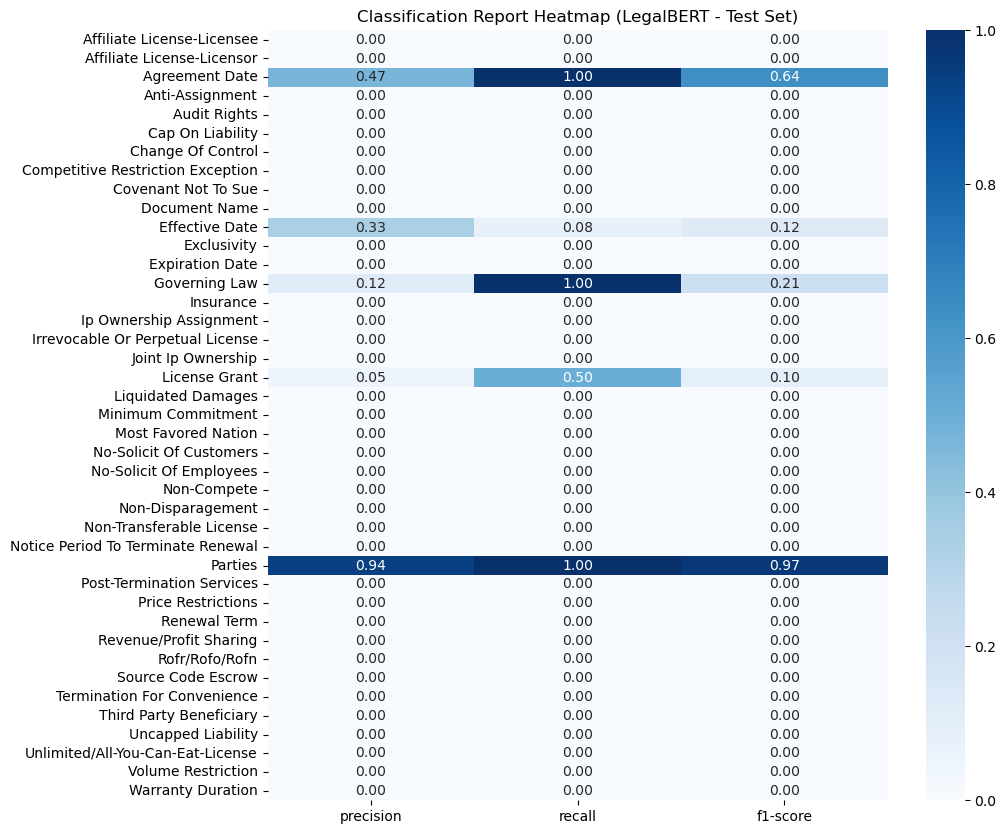

In [452]:
# Step 6: Convert to DataFrame and plot heatmap
df_report = pd.DataFrame(report_dict).transpose().iloc[:-3]  # remove avg rows

plt.figure(figsize=(10, 10))
sns.heatmap(df_report[["precision", "recall", "f1-score"]], annot=True, fmt=".2f", cmap="Blues")
plt.title("Classification Report Heatmap (LegalBERT - Test Set)")
plt.yticks(rotation=0)
plt.show()

In [454]:
# Step 1: Load the saved model and tokenizer
model = BertForSequenceClassification.from_pretrained("bert_clause_classifier")
tokenizer = BertTokenizer.from_pretrained("bert_clause_classifier")

# Step 2: Recreate the Trainer
trainer = Trainer(model=model)

# Step 3: Get predictions on the test dataset
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Step 4: Force labels to use full class range
label_indices = list(range(len(class_names)))  # e.g., 0 to 40 if 41 classes

# Step 5: Generate classification report
report_dict = classification_report(
    true_labels,
    pred_labels,
    labels=label_indices,
    target_names=class_names,
    output_dict=True,
    zero_division=0
)

C:\Users\Ryhana Rasidi\AppData\Local\Temp\ipykernel_5288\3762311827.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\Ryhana Rasidi\AppData\Local\Temp\ipykernel_5288\3762311827.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)


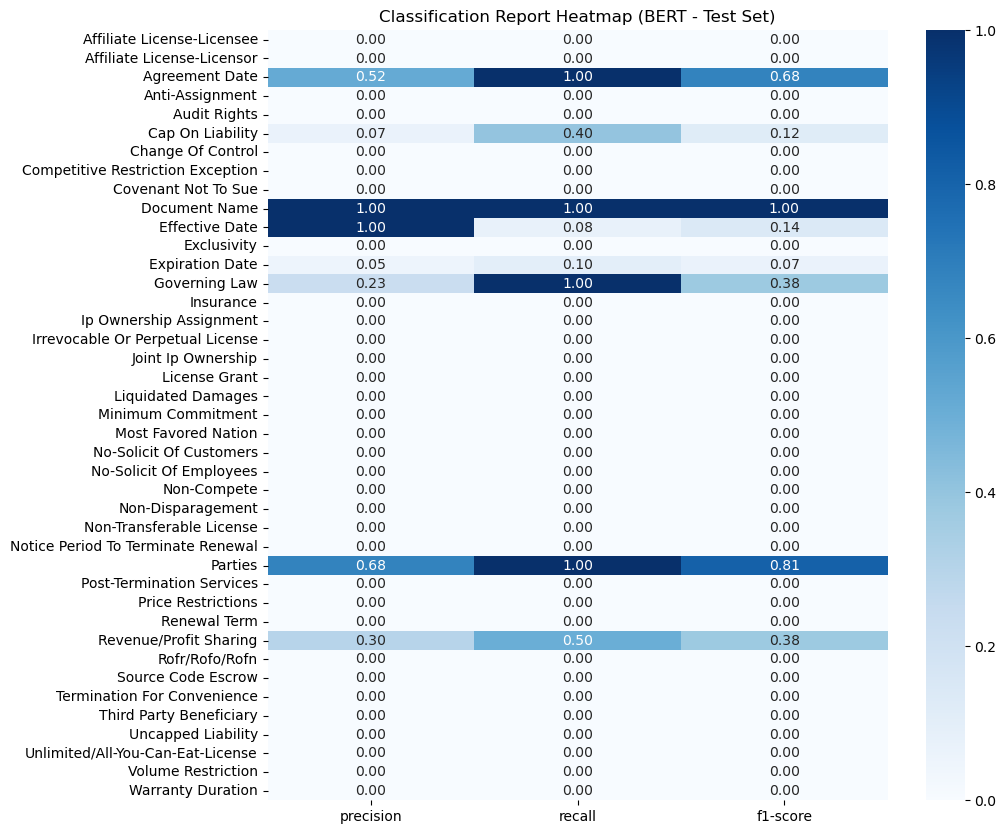

In [456]:
# Step 6: Convert to DataFrame and plot heatmap
df_report = pd.DataFrame(report_dict).transpose().iloc[:-3]  # remove avg rows

plt.figure(figsize=(10, 10))
sns.heatmap(df_report[["precision", "recall", "f1-score"]], annot=True, fmt=".2f", cmap="Blues")
plt.title("Classification Report Heatmap (BERT - Test Set)")
plt.yticks(rotation=0)
plt.show()